This file contains the code of th Faster R-CNN process.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch torchvision torchaudio
!pip install pycocotools  # for COCO evaluation


In [ ]:
import os, glob, cv2, torch
from torch.utils.data import Dataset, DataLoader

class YoloFaceDataset(Dataset):
    def __init__(self, img_dir, label_dir, class_names, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.class_names = class_names
        self.transforms = transforms
        # support jpg/png/jpeg
        self.img_files = sorted(
            glob.glob(os.path.join(img_dir, "*.jpg")) +
            glob.glob(os.path.join(img_dir, "*.png")) +
            glob.glob(os.path.join(img_dir, "*.jpeg"))
        )
        print(f"Found {len(self.img_files)} images in {img_dir}")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.img_files[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        # Load YOLO txt
        label_path = os.path.join(
            self.label_dir, os.path.basename(img_path).rsplit(".",1)[0] + ".txt"
        )
        boxes, labels = [], []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, xc, yc, bw, bh = map(float, line.strip().split())
                    cls = int(cls)
                    # YOLO → Pascal VOC absolute
                    xmin = (xc - bw/2) * w
                    ymin = (yc - bh/2) * h
                    xmax = (xc + bw/2) * w
                    ymax = (yc + bh/2) * h
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(cls + 1)  # shift: YOLO 0→1, 1→2

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        image = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [ ]:
CLASS_NAMES = ["Normal", "Crying"]  # your classes
num_classes = 1 + len(CLASS_NAMES)  # background + 2

train_dataset = YoloFaceDataset(
    img_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/images/train",
    label_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/labels/train",
    class_names=CLASS_NAMES
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn
)


Found 753 images in /content/drive/MyDrive/total_dataset/dataset_80_10_10/images/train


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load pretrained Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 178MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
train_dataset = YoloFaceDataset(
    img_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/images/train",
    label_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/labels/train",
    class_names=CLASS_NAMES
)

val_dataset = YoloFaceDataset(
    img_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/images/val",
    label_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/labels/val",
    class_names=CLASS_NAMES
)

test_dataset = YoloFaceDataset(
    img_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/images/test",
    label_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/labels/test",
    class_names=CLASS_NAMES
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


Found 753 images in /content/drive/MyDrive/total_dataset/dataset_80_10_10/images/train
Found 94 images in /content/drive/MyDrive/total_dataset/dataset_80_10_10/images/val
Found 95 images in /content/drive/MyDrive/total_dataset/dataset_80_10_10/images/test


In [ ]:
import torch

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 20  # you can increase
best_loss = float("inf")
patience = 5
trigger_times = 0

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)   # dict of losses
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}")

    # --- Validation ---
    val_loss = 0
    with torch.no_grad():
        model.train()  # <-- keep train() so it returns losses
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # --- Early Stopping ---
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_frcnn.pth")
        print("✅ Saved new best model")
    else:
        trigger_times += 1
        print(f"⚠️ No improvement. Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("⏹️ Early stopping triggered")
            break


Epoch [1/20] Train Loss: 0.1831
Validation Loss: 0.1402
✅ Saved new best model
Epoch [2/20] Train Loss: 0.1209
Validation Loss: 0.1247
✅ Saved new best model
Epoch [3/20] Train Loss: 0.1025
Validation Loss: 0.1101
✅ Saved new best model
Epoch [4/20] Train Loss: 0.0848
Validation Loss: 0.1056
✅ Saved new best model
Epoch [5/20] Train Loss: 0.0755
Validation Loss: 0.0945
✅ Saved new best model
Epoch [6/20] Train Loss: 0.0702
Validation Loss: 0.0922
✅ Saved new best model
Epoch [7/20] Train Loss: 0.0594
Validation Loss: 0.0869
✅ Saved new best model
Epoch [8/20] Train Loss: 0.0545
Validation Loss: 0.0954
⚠️ No improvement. Trigger times: 1/5
Epoch [9/20] Train Loss: 0.0523
Validation Loss: 0.0834
✅ Saved new best model
Epoch [10/20] Train Loss: 0.0456
Validation Loss: 0.0867
⚠️ No improvement. Trigger times: 1/5
Epoch [11/20] Train Loss: 0.0393
Validation Loss: 0.1002
⚠️ No improvement. Trigger times: 2/5
Epoch [12/20] Train Loss: 0.0364
Validation Loss: 0.0803
✅ Saved new best model
Epoc

In [ ]:
save_path = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/best_frcnn.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved at {save_path}")


✅ Model saved at /content/drive/MyDrive/total_dataset/dataset_80_10_10/best_frcnn.pth


In [ ]:
# Rebuild the model head
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load trained weights
model.load_state_dict(torch.load("best_frcnn.pth", map_location=device))
model.to(device)
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import numpy as np

def box_iou(box1, box2):
    """Compute IoU between two boxes [xmin, ymin, xmax, ymax]."""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (box1[2] - box1[0]) * (box1[3] - box1[1])
    boxBArea = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

ious = []
correct = 0
total = 0

with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        gt_boxes = targets[0]["boxes"].cpu().numpy()
        pred_boxes = outputs[0]["boxes"].cpu().numpy()
        pred_scores = outputs[0]["scores"].cpu().numpy()
        pred_labels = outputs[0]["labels"].cpu().numpy()

        # Take only high confidence predictions
        keep = pred_scores >= 0.5
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]

        for gt in gt_boxes:
            total += 1
            if len(pred_boxes) > 0:
                ious_per_gt = [box_iou(gt, pred) for pred in pred_boxes]
                best_iou = max(ious_per_gt)
                ious.append(best_iou)
                if best_iou >= 0.5:  # count as correct detection
                    correct += 1

# Final metrics
mean_iou = np.mean(ious) if ious else 0
accuracy = correct / total if total > 0 else 0
print(f"✅ Test Results: mean IoU={mean_iou:.4f}, Accuracy={accuracy:.4f}")


✅ Test Results: mean IoU=0.8199, Accuracy=1.0000


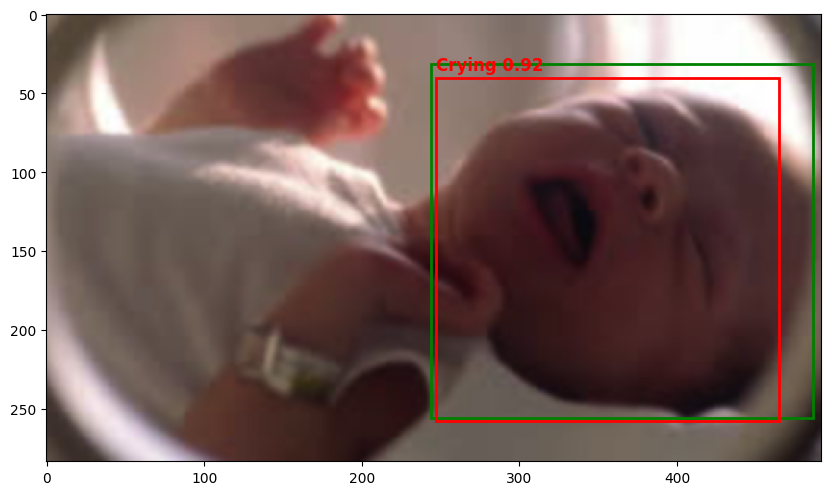

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def visualize_test(idx=0, threshold=0.5):
    img, target = test_dataset[idx]
    model.eval()
    with torch.no_grad():
        pred = model([img.to(device)])[0]

    fig, ax = plt.subplots(1, figsize=(10,8))
    ax.imshow(img.permute(1,2,0).cpu().numpy())

    # GT boxes (green)
    for box in target["boxes"]:
        box = box.cpu().numpy()
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                 linewidth=2, edgecolor="green", facecolor="none")
        ax.add_patch(rect)

    # Pred boxes (red)
    for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]):
        if score >= threshold:
            box = box.cpu().numpy()
            score = float(score.cpu().item())
            label = int(label.cpu().item())

            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                     linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.text(xmin, ymin-5, f"{CLASS_NAMES[label-1]} {score:.2f}",
                    color="red", fontsize=12, weight="bold")

    plt.show()

visualize_test(0)

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/best_frcnn.pth"

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Model file not found at {MODEL_PATH}")

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


<All keys matched successfully>

Found 95 images in /content/drive/MyDrive/total_dataset/dataset_80_10_10/images/test
✅ Model loaded successfully from: /content/drive/MyDrive/total_dataset/dataset_80_10_10/best_frcnn.pth
✅ Test Results:
Precision: 0.9442
Recall:    0.8947
F1-score:  0.9186
Accuracy:  0.8947


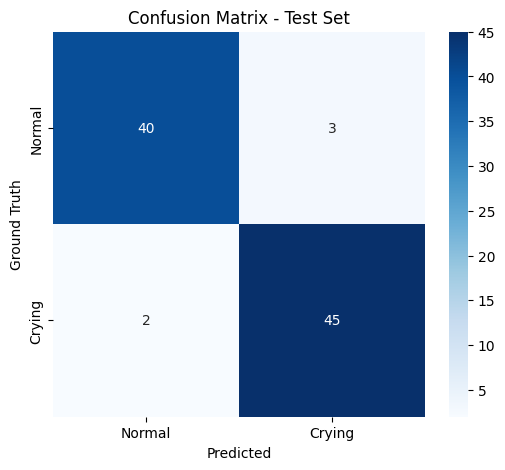

IndexError: index 1 is out of bounds for axis 1 with size 1

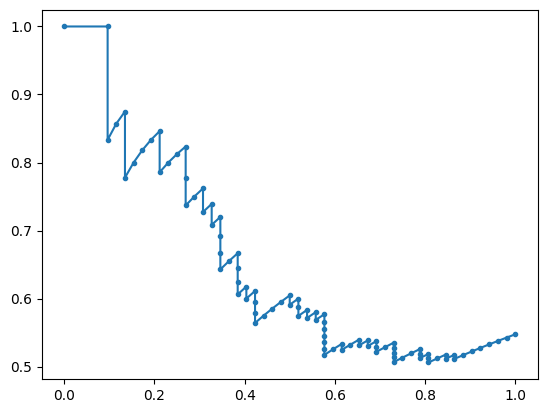

In [ ]:
import os, torch, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

# ==== Setup ====
SAVE_DIR = "/content/drive/MyDrive/total_dataset/fastercnn/testing_result"
os.makedirs(SAVE_DIR, exist_ok=True)

CLASS_NAMES = ["Normal", "Crying"]  # dataset classes
num_classes = 1 + len(CLASS_NAMES)  # background + 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Load test dataset ====
test_dataset = YoloFaceDataset(
    img_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/images/test",
    label_dir="/content/drive/MyDrive/total_dataset/dataset_80_10_10/labels/test",
    class_names=CLASS_NAMES
)

def collate_fn(batch): return tuple(zip(*batch))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# ==== Load model ====
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Path to your trained weights in Google Drive
MODEL_PATH = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/best_frcnn.pth"

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

# Check if file exists before loading
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Model file not found at {MODEL_PATH}")

checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint)
print(f"✅ Model loaded successfully from: {MODEL_PATH}")

model.to(device).eval()


# ==== IoU helper ====
def box_iou(box1, box2):
    xA = max(box1[0], box2[0]); yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2]); yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (box1[2]-box1[0]) * (box1[3]-box1[1])
    boxBArea = (box2[2]-box2[0]) * (box2[3]-box2[1])
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

# ==== Evaluation Loop ====
all_targets, all_preds, all_confidences, all_true_bin, all_score_bin = [], [], [], [], []

with torch.no_grad():
    for idx in range(len(test_dataset)):
        img, target = test_dataset[idx]
        pred = model([img.to(device)])[0]

        # Prepare figure
        fig, ax = plt.subplots(1, figsize=(10,8))
        ax.imshow(img.permute(1,2,0).cpu().numpy())

        gt_boxes = target["boxes"].cpu().numpy()
        gt_labels = target["labels"].cpu().numpy()

        # Draw GT (green)
        for box in gt_boxes:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                                     linewidth=2, edgecolor="green", facecolor="none")
            ax.add_patch(rect)

        # Predictions
        pred_boxes = pred["boxes"].cpu().numpy()
        pred_scores = pred["scores"].cpu().numpy()
        pred_labels = pred["labels"].cpu().numpy()

        keep = pred_scores >= 0.5
        pred_boxes, pred_scores, pred_labels = pred_boxes[keep], pred_scores[keep], pred_labels[keep]

        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                                     linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.text(xmin, ymin-5, f"{CLASS_NAMES[label-1]} {score:.2f}",
                    color="red", fontsize=12, weight="bold")

        plt.axis("off")
        plt.savefig(os.path.join(SAVE_DIR, f"result_{idx}.jpg"), bbox_inches="tight")
        plt.close(fig)

        # === Metrics ===
        for gt, gt_label in zip(gt_boxes, gt_labels):
            if len(pred_boxes) > 0:
                ious = [box_iou(gt, pb) for pb in pred_boxes]
                best_idx = np.argmax(ious); best_iou = ious[best_idx]
                if best_iou >= 0.5:
                    pred_class = pred_labels[best_idx]
                    pred_conf  = pred_scores[best_idx]
                else:
                    pred_class, pred_conf = 0, 0.0
            else:
                pred_class, pred_conf = 0, 0.0

            all_targets.append(int(gt_label))
            all_preds.append(int(pred_class))
            all_confidences.append(float(pred_conf))

            # Binary labels for PR curve (1 = Crying, 0 = Normal)
            all_true_bin.append(1 if gt_label==2 else 0)
            all_score_bin.append(pred_conf if pred_class==2 else 1-pred_conf)

# ==== Metrics ====
precision = precision_score(all_targets, all_preds, average="weighted", zero_division=0)
recall    = recall_score(all_targets, all_preds, average="weighted", zero_division=0)
f1        = f1_score(all_targets, all_preds, average="weighted", zero_division=0)
accuracy  = accuracy_score(all_targets, all_preds)

print("✅ Test Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

# ==== Confusion Matrix ====
cm = confusion_matrix(all_targets, all_preds, labels=[1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted"); plt.ylabel("Ground Truth")
plt.title("Confusion Matrix - Test Set")
plt.show()

# ==== Precision-Recall Curves ====
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(all_targets, classes=[1,2])  # shape (N,2)
y_score_bin = np.array([[1-c, c] for c in all_confidences])  # crude prob approx

for i, class_name in enumerate(CLASS_NAMES):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score_bin[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score_bin[:, i])

    plt.plot(recall, precision, marker='.', label=f"{class_name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Test Set)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
precision = precision_score(all_targets, all_preds, average="weighted", zero_division=0)
recall = recall_score(all_targets, all_preds, average="weighted", zero_division=0)
f1 = f1_score(all_targets, all_preds, average="weighted", zero_division=0)
accuracy = accuracy_score(all_targets, all_preds)

print("✅ Evaluation Metrics on Test Set:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


✅ Evaluation Metrics on Test Set:
Precision: 0.9785
Recall:    0.9474
F1-score:  0.9627
Accuracy:  0.9474


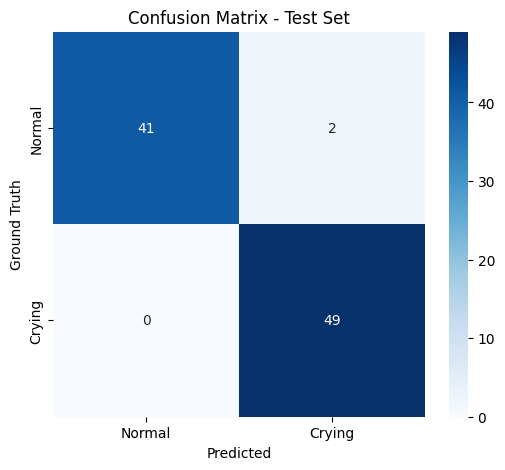

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Build confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=[1, 2])
# 1 = Normal, 2 = Crying (since 0 = background, we skip it)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)

plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix - Test Set")
plt.show()
